# <center><font color='blue'>SkimLit</center></font>

## Table of contents
- [1 - Objectives](#1)
- [2 - Setup](#2)
- [3 - Data Loading and Visualization](#3)
- [4 - Data pre-processing](#4)
    - [4.1. - Formatting our data](#4.1)
    - [4.2. - More visualization](#4.2)
    - [4.3. - Categorical data](#4.3)
    - [4.4. - Pre-processing for NLP](#4.4)
    - [4.5. - Creating tensorflow datasets](#4.5)
- [5 - Models](#5)
    - [5.1. - Embedding layer](#5.1)
    - [5.2. - Trying different models](#5.2)
        - [5.2.0 - Baseline](#5.2.0)
        - [5.2.1 - Model 1](#5.2.1)
        - [5.2.2 - Model 2](#5.2.2)
        - [5.2.3 - Model 3](#5.2.3)
        - [5.2.4 - Model 4](#5.2.4)
        - [5.2.5 - Model 5](#5.2.5)
- [6 - Compare results](#6)
- [7 - Conclusions](#7)
- [8 - References](#8)


<a name="1"></a>
## <b> <font color='blue'> 1. Objectives </font> </b>
Build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071



<a name="2"></a>
## <b> <font color='blue'> 2. Setup </font> </b>

What we are looking for is to associate a specific label (objective, background, result...) with a given sentence (composed of many words), so it is a many-to-one problem.

### Modules

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import csv
import random
import re

import numpy as np

import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models, Sequential, losses
from tensorflow import keras

from utils import plot_hist


C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# random seed
tf.random.set_seed(42)

<a name="3"></a>
## <b> <font color='blue'> 3.  Data Loading and Visualization </font> </b>

Let's download the data.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!dir pubmed-rct #ls

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


 Volume in drive C is OS

File Not Found



 Volume Serial Number is 9222-4A02

 Directory of C:\Users\marco\Desktop\IA\NLP\Skim Lit\pubmed-rct

07/25/2024  07:45 PM    <DIR>          .
07/27/2024  01:21 PM    <DIR>          ..
07/25/2024  07:45 PM    <DIR>          PubMed_200k_RCT
07/25/2024  07:45 PM    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
07/25/2024  07:45 PM    <DIR>          PubMed_20k_RCT
07/25/2024  07:45 PM    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
07/25/2024  07:45 PM             3,733 README.md
               1 File(s)          3,733 bytes

 Directory of C:\Users\marco\Desktop\IA\NLP\Skim Lit



There are 2 datasets, one with 20000 examples (usefull for the initial tests) and another one with 200k examples.

In [5]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
# Let's read in the training lines and see some of them
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file

to_show = 15
train_lines[:to_show]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We see that the abstracts:

- Start with "###
- Followed by an ID and a newline character (\n)
- Each sentence has a label (for example RESULTS, METHODS..) (starting with the label and then \t)
- The end is indicated by a newline charecter (\n).

<br>
We need a function to separate the text from the labels and the different abstracts.

<a name="4"></a>
## <b> <font color='blue'> 4.  Data pre-processing </font> </b>


<a name="4.1"></a>
### <b> <font color='#1F618D'> 4.1. Formatting our data </font> </b>

We want that our data looks like this:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

total lines it's the number of lines in the abstract (that we want to classify sequentially)

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.


In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

          

In [11]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [12]:
# Check the first abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Let's create dataframes:

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<a name="4.2"></a>
### <b> <font color='#1F618D'> 4.2. More visualization </font> </b>

#### Number of classes and class balance

In [14]:
num_classes = train_df['target'].nunique()
num_classes

5

In [15]:
# Distribution of labels in training data
train_df.target.value_counts(normalize=True)

target
METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: proportion, dtype: float64

#### Total lines distribution

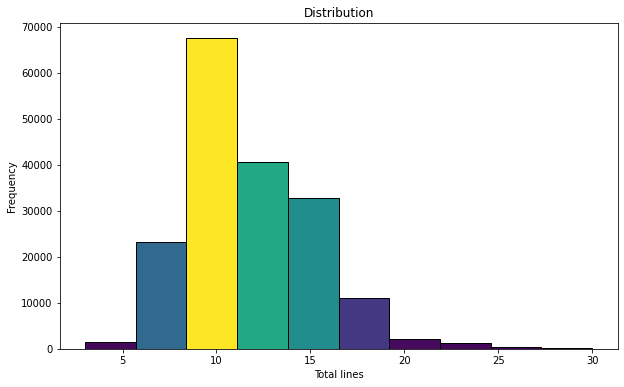

In [16]:
plot_hist(train_df['total_lines'], 'Distribution', 'Total lines', 'Frequency', 10)

#### Sentences

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [19]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

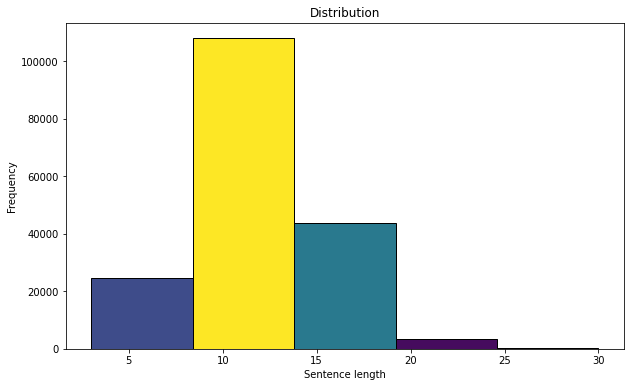

In [20]:
plot_hist(train_df['total_lines'], 'Distribution', 'Sentence length', 'Frequency', 5)

In [21]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [22]:
# Maximum sequence length in the training set
max(sent_lens)

296

<a name="4.3"></a>
### <b> <font color='#1F618D'> 4.3. Categorical Data </font> </b>

We will use one-hot encoding for our targets, since there are no ordinal relationship between them.

In [23]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))

# here there is no fit, we fit with the training data only
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a name="4.4"></a>
### <b> <font color='#1F618D'> 4.4. Pre-processing for NLP </font> </b>

#### Create text vectorizer layer

In [24]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [25]:
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import TextVectorization


# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [26]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [27]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
we analyzed feasibility and reproducibility of right heart functional analysis by measuring ccta-based tricuspid annular plane systolic excursion ( ct-tapse ) on ecg-gated ccta and correlated the results with @d transthoracic echocardiography ( tte ) - derived tapse ( echo-tapse ) .

Length of text: 42

Vectorized text: [[   43   384   702     3  5538     4  1258   260   304    85    22  2110
  61886 12328 10455  4017   680  9425 18953    18 39400  6823     3   752
      2   117     7   187  7136  2125  6999  1919 16464 23280     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Let's observe that it pads with zeros up to the specified output sequence length (output_seq_length, which is 55 in this case).

In [28]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

<b> 
We will apply it later as the first layer of the model after obtaining the input. </b>

<a name="4.5"></a>
### <b> <font color='#1F618D'> 4.5. Creating tensorflow datasets </font> </b>

In [30]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


In [31]:
for x, y in train_dataset.take(1):
    print(f"Text: {x}\n")
    print(f"Label: {y}")

Text: b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

Label: [0. 0. 0. 1. 0.]


In [32]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

<a name="5"></a>
## <b> <font color='blue'> 5. Models </font> </b>

In [33]:
from utils import store_results

In [34]:
# to save results and compare
results = {}

In [35]:
# constants
INPUT_SHAPE=(1,)
BATCH_SIZE = 32
NUM_CLASSES=num_classes

<a name="5.1"></a>
### <b> <font color='#1F618D'> 5.1. Embedding layer </font> </b>

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt 
                                               #numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 we analyzed feasibility and reproducibility of right heart functional analysis by measuring ccta-based tricuspid annular plane systolic excursion ( ct-tapse ) on ecg-gated ccta and correlated the results with @d transthoracic echocardiography ( tte ) - derived tapse ( echo-tapse ) .

Sentence after vectorization (before embedding):
 [[   43   384   702     3  5538     4  1258   260   304    85    22  2110
  61886 12328 10455  4017   680  9425 18953    18 39400  6823     3   752
      2   117     7   187  7136  2125  6999  1919 16464 23280     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.03738235  0.01134907 -0.01695945 ... -0.03231644  0.02243985
    0.03344803]
  [-0.02709289 -0.03256481 -0.01042875 ...  0.03713447  0.00417744
   -0.04343041]
  [-0.03865472  0.02190634 -0.03322254 ... -0.04610516 -0.02973052
   -0.01052828]
  ...
  [-0.03

<a name="5.2"></a>
### <b> <font color='#1F618D'> 5.2. Trying different models </font> </b>

<a name="5.2.0"></a>
### <b> <font color='#5499C7'> 5.2.0. Baseline </font> </b>

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [127]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [128]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [129]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [130]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [142]:
def calculate_metrics(model, y_true, y_pred):
    # preds
    val_predictions = model_0.predict(val_sentences)

    # precision, recall, accuracy
    precision = precision_score(val_labels_encoded, val_predictions, average='weighted')
    recall = recall_score(val_labels_encoded, val_predictions, average='weighted')
    accuracy = accuracy_score(val_labels_encoded, val_predictions)
    
    # return 
    return ['NA', accuracy, precision, recall]
    

In [144]:
# val metrics
val_results = calculate_metrics(model_0, val_labels_encoded, val_predictions)
val_results

['NA', 0.7218323844829869, 0.7186466952323352, 0.7218323844829869]

In [145]:
# test metrics
test_results = calculate_metrics(model_0, test_labels_encoded, test_predictions)
test_results

['NA', 0.7218323844829869, 0.7186466952323352, 0.7218323844829869]

In [146]:
store_results(results, 'Baseline', test_results);

In [141]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

<a name="5.2.1"></a>
### <b> <font color='#5499C7'> 5.2.1. Model 1: Conv1D </font> </b>

In [38]:
def build_model_1(name, input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = text_vectorizer(inputs)
    x = token_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_1 = build_model_1('model_1')

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                           

In [39]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy', 'Precision', 'Recall']
)


history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    batch_size=BATCH_SIZE,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 90s 153ms/step - loss: 0.9166 - accuracy: 0.6385 - precision: 0.8406 - recall: 0.4381 - val_loss: 0.6882 - val_accuracy: 0.7367 - val_precision: 0.8159 - val_recall: 0.6423
Epoch 2/3
562/562 [==============================] - 84s 150ms/step - loss: 0.6605 - accuracy: 0.7552 - precision: 0.8163 - recall: 0.6693 - val_loss: 0.6413 - val_accuracy: 0.7696 - val_precision: 0.8341 - val_recall: 0.6652
Epoch 3/3
562/562 [==============================] - 85s 151ms/step - loss: 0.6217 - accuracy: 0.7711 - precision: 0.8258 - recall: 0.7011 - val_loss: 0.6017 - val_accuracy: 0.7826 - val_precision: 0.8413 - val_recall: 0.7031


In [40]:
# evaluate
score1 = model_1.evaluate(test_dataset)

942/942 [==============================] - 12s 12ms/step - loss: 0.6174 - accuracy: 0.7785 - precision: 0.8318 - recall: 0.7018


In [41]:
store_results(results, 'Model 1', score1);

In [43]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 11s 11ms/step


(array([[4.1994888e-01, 1.8717369e-01, 7.5651109e-02, 2.9493976e-01,
         2.2286477e-02],
        [4.3749273e-01, 2.8676730e-01, 1.4593183e-02, 2.5283420e-01,
         8.3125504e-03],
        [1.4549446e-01, 5.9267236e-03, 1.9467825e-03, 8.4659672e-01,
         3.5193123e-05],
        ...,
        [6.2812578e-06, 7.8687613e-04, 6.4676901e-04, 5.5087148e-06,
         9.9855453e-01],
        [5.2205488e-02, 4.2164463e-01, 1.0380326e-01, 6.8839721e-02,
         3.5350689e-01],
        [1.7562309e-01, 6.9195533e-01, 3.5255965e-02, 4.7310084e-02,
         4.9855571e-02]], dtype=float32),
 (30212, 5))

In [44]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

<a name="5.2.2"></a>
### <b> <font color='#5499C7'> 5.2.2. Model 2: Feature extraction with pre-trained token embeddings </font> </b>

In [45]:
import tensorflow_hub as hub

In [46]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 it will also investigate predictors of outcome and retention for these interventions .
Setence after embedding:
[ 0.03684489  0.00597197  0.0069445  -0.01115389 -0.07425143 -0.04175424
 -0.02038428 -0.00139778 -0.09008218  0.01210241  0.04393999 -0.02892707
  0.02407878 -0.02312291 -0.0420863   0.00378637 -0.04960603  0.03620855
  0.00691195  0.07697517  0.08193678  0.07925475  0.0503446  -0.03745197
 -0.03548519  0.02791214  0.04367737 -0.01659125 -0.04333917  0.01554998]

Length of sentence embedding: 512


In [48]:
def build_model_2(name, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape, dtype=tf.string)
    x = tf_hub_embedding_layer()(inputs)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_2 = build_model_1('model_2_USE_feature_extractor')
    
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                     

In [49]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # one-hot encoded labels
    metrics=['accuracy', 'Precision', 'Recall']
)


history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 93s 161ms/step - loss: 0.6653 - accuracy: 0.7618 - precision: 0.8685 - recall: 0.6255 - val_loss: 0.6139 - val_accuracy: 0.7729 - val_precision: 0.8194 - val_recall: 0.7121
Epoch 2/3
562/562 [==============================] - 90s 160ms/step - loss: 0.5007 - accuracy: 0.8224 - precision: 0.8585 - recall: 0.7725 - val_loss: 0.6093 - val_accuracy: 0.7749 - val_precision: 0.8201 - val_recall: 0.7124
Epoch 3/3
562/562 [==============================] - 91s 162ms/step - loss: 0.4823 - accuracy: 0.8288 - precision: 0.8633 - recall: 0.7883 - val_loss: 0.5954 - val_accuracy: 0.7862 - val_precision: 0.8266 - val_recall: 0.7337


In [50]:
# evaluate
score2 = model_2.evaluate(test_dataset)

942/942 [==============================] - 12s 12ms/step - loss: 0.6122 - accuracy: 0.7828 - precision: 0.8203 - recall: 0.7346


In [51]:
store_results(results, 'Model 2', score2);

In [52]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[5.3487819e-01, 1.4640376e-01, 5.7741396e-02, 2.3852803e-01,
        2.2448596e-02],
       [3.9297226e-01, 2.6947251e-01, 2.2416880e-02, 3.0401257e-01,
        1.1125827e-02],
       [1.0297067e-01, 1.1406132e-03, 4.8926251e-04, 8.9539248e-01,
        6.9597791e-06],
       ...,
       [1.2076465e-06, 1.4811162e-04, 2.0909608e-04, 5.4160006e-07,
        9.9964106e-01],
       [6.1146248e-02, 5.8052826e-01, 6.4344108e-02, 5.8828525e-02,
        2.3515289e-01],
       [7.3186696e-02, 8.9294142e-01, 1.3353117e-02, 8.4310872e-03,
        1.2087553e-02]], dtype=float32)

In [53]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

<a name="5.2.3"></a>
### <b> <font color='#5499C7'> 5.2.3. Model 3: Conv1D with character embeddings </font> </b>

#### Creating a character-level tokenizer

In [54]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [55]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [56]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [57]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

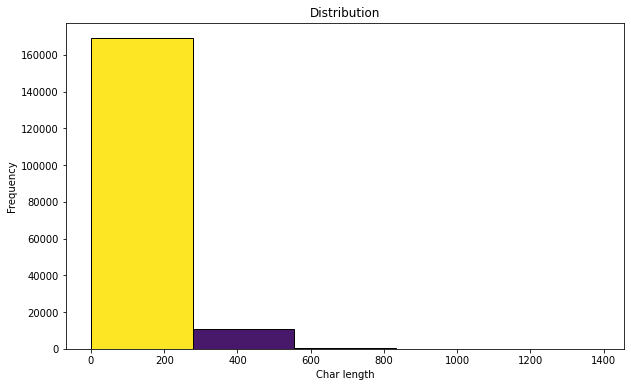

In [59]:
plot_hist(char_lens, 'Distribution', 'Char length', 'Frequency', 5)

In [60]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [63]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 a f t e r   c o n t r o l l i n g   f o r   g e n d e r   ,   p a i n   s e v e r i t y   a c c o u n t e d   f o r   @   %   o f   t h e   v a r i a n c e   i n   p a t i e n t   f u n c t i o n a l   d i s a b i l i t y   .

Length of random_train_chars: 95

Vectorized chars:
 [[ 5 17  3  2  8 11  7  6  3  8  7 12 12  4  6 18 17  7  8 18  2  6 10  2
   8 14  5  4  6  9  2 21  2  8  4  3 19  5 11 11  7 16  6  3  2 10 17  7
   8  7 17  3 13  2 21  5  8  4  5  6 11  2  4  6 14  5  3  4  2  6  3 17
  16  6 11  3  4  7  6  5 12 10  4  9  5 22  4 12  4  3 19  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0

#### Creating a character-level embedding

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [67]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 a f t e r   c o n t r o l l i n g   f o r   g e n d e r   ,   p a i n   s e v e r i t y   a c c o u n t e d   f o r   @   %   o f   t h e   v a r i a n c e   i n   p a t i e n t   f u n c t i o n a l   d i s a b i l i t y   .

Embedded chars (after vectorization and embedding):
 [[[-0.01693394  0.00888735  0.0352382  ...  0.00687528  0.01061555
    0.04443869]
  [ 0.04372701 -0.04603447 -0.00039984 ...  0.02640369 -0.03807453
   -0.00491899]
  [ 0.0129925   0.01678411 -0.03103091 ...  0.0149125   0.04787837
    0.00376099]
  ...
  [ 0.04235579  0.01720918 -0.03801522 ... -0.03705624 -0.02626889
    0.02125824]
  [ 0.04235579  0.01720918 -0.03801522 ... -0.03705624 -0.02626889
    0.02125824]
  [ 0.04235579  0.01720918 -0.03801522 ... -0.03705624 -0.02626889
    0.02125824]]]

Character embedding shape: (1, 290, 25)


Each sentence has length 290 and the size of the embedding is 25.

In [68]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [69]:
def build_model_3(name, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = char_vectorizer(inputs)
    x = char_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # try MaxPooling!!
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model

    
model_3 = build_model_3('model_3')

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 5)                 325 

In [70]:
# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy", 'Precision', 'Recall'])

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 28ms/step - loss: 1.4610 - accuracy: 0.3536 - precision: 0.7111 - recall: 0.0018 - val_loss: 1.4022 - val_accuracy: 0.4036 - val_precision: 0.7826 - val_recall: 0.0060
Epoch 2/3
562/562 [==============================] - 15s 26ms/step - loss: 1.3662 - accuracy: 0.4251 - precision: 0.6678 - recall: 0.0763 - val_loss: 1.3352 - val_accuracy: 0.4441 - val_precision: 0.6505 - val_recall: 0.1423
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 1.3249 - accuracy: 0.4531 - precision: 0.6491 - recall: 0.1611 - val_loss: 1.3133 - val_accuracy: 0.4475 - val_precision: 0.6434 - val_recall: 0.1835


In [71]:
score3 = model_3.evaluate(test_char_dataset)

942/942 [==============================] - 11s 12ms/step - loss: 1.3181 - accuracy: 0.4483 - precision: 0.6590 - recall: 0.1943


In [72]:
store_results(results, 'Model 3', score3);

In [73]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.17738485, 0.23053119, 0.28426492, 0.15578644, 0.15203257],
       [0.10688296, 0.16541864, 0.15176317, 0.0665385 , 0.5093968 ],
       [0.09456684, 0.13916342, 0.47213086, 0.09395172, 0.20018704],
       ...,
       [0.06114127, 0.10283488, 0.22745553, 0.04233255, 0.56623584],
       [0.04239868, 0.09654415, 0.19476843, 0.04601869, 0.6202701 ],
       [0.14223601, 0.17807215, 0.20312712, 0.07143331, 0.40513146]],
      dtype=float32)

In [74]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4], dtype=int64)>

<a name="5.2.4"></a>
### <b> <font color='#5499C7'> 5.2.4. Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer) </font> </b>

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

<img src="images/model_4.png">


<br>
<center> <b>Figure</b> Model.</center>

crédtiso a la imagen!!!



In [75]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
        # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# Repeat the above steps for our test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # combine data and labels
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [79]:
def build_model_4(name):
    # 1. Setup token inputs/model
    token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
    token_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs,
                                 outputs=token_outputs)

    # 2. Setup char inputs/model
    char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Concatenate token and char inputs (create hybrid token embedding)
    token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                      char_model.output])

    # 4. Create output layers
    combined_dropout = layers.Dropout(0.5)(token_char_concat)
    combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
    final_dropout = layers.Dropout(0.5)(combined_dense)
    output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

    # 5. Construct model with char and token inputs
    model = tf.keras.Model(inputs=[token_model.input, char_model.input],
                             outputs=output_layer,
                             name="model_4_token_and_char_embeddings")
    #
    return model


model_4 = build_model_4('Model 4')

model_4.summary()


Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [80]:
# to plot the model
from keras.utils import plot_model

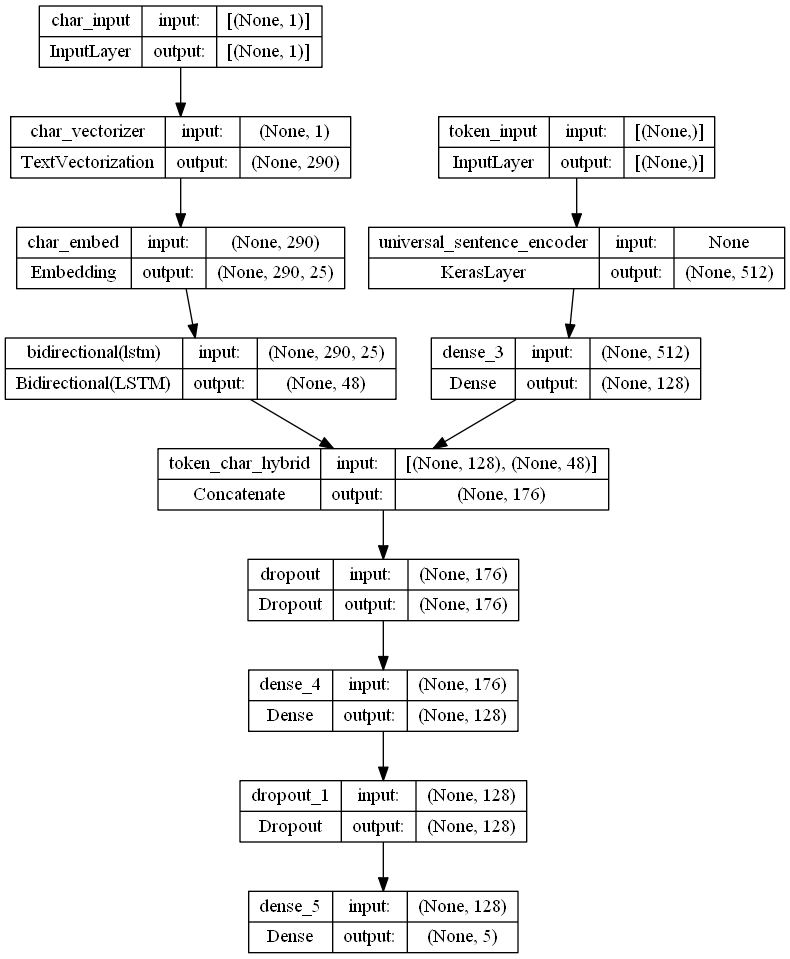

In [81]:
plot_model(model_4, show_shapes=True)

In [82]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy", 'Precision', 'Recall'])

# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 217s 336ms/step - loss: 0.9909 - accuracy: 0.6030 - precision: 0.7647 - recall: 0.4251 - val_loss: 0.8010 - val_accuracy: 0.6985 - val_precision: 0.7931 - val_recall: 0.5542
Epoch 2/3
562/562 [==============================] - 184s 327ms/step - loss: 0.8108 - accuracy: 0.6863 - precision: 0.7710 - recall: 0.5758 - val_loss: 0.7298 - val_accuracy: 0.7241 - val_precision: 0.8061 - val_recall: 0.6207
Epoch 3/3
562/562 [==============================] - 174s 310ms/step - loss: 0.7782 - accuracy: 0.7052 - precision: 0.7880 - recall: 0.6088 - val_loss: 0.7025 - val_accuracy: 0.7357 - val_precision: 0.8098 - val_recall: 0.6426


In [83]:
score4 = model_4.evaluate(test_char_token_dataset)

942/942 [==============================] - 78s 83ms/step - loss: 0.7216 - accuracy: 0.7237 - precision: 0.7996 - recall: 0.6348


In [84]:
store_results(results, 'Model 4', score4);

In [85]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(test_char_token_dataset)
model_4_pred_probs

942/942 [==============================] - 43s 43ms/step


array([[3.40614945e-01, 2.29843572e-01, 8.13756436e-02, 2.98375279e-01,
        4.97904606e-02],
       [2.54976720e-01, 1.11711495e-01, 1.43074974e-01, 4.66898590e-01,
        2.33383160e-02],
       [8.95128527e-04, 2.06098589e-03, 8.74536037e-01, 5.37900603e-04,
        1.21969990e-01],
       ...,
       [3.58909019e-04, 1.92485303e-02, 2.65403762e-02, 1.33551832e-04,
        9.53718662e-01],
       [4.79361787e-03, 6.41180798e-02, 5.71685918e-02, 2.26266962e-03,
        8.71657073e-01],
       [4.38178033e-02, 7.05094039e-01, 1.05041943e-01, 1.31607978e-02,
        1.32885441e-01]], dtype=float32)

In [86]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 3, 2, ..., 4, 4, 1], dtype=int64)>

<a name="5.2.5"></a>
### <b> <font color='#5499C7'> 5.2.5. Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings</font> </b>

We are going to include positional embeddings because order is important; if a sentence is the first in an abstract, it is more likely to be the objective or the background, if it is the last one, it is more likely to be the conclusion...

In [87]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

#### Create positional embeddings

In [88]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

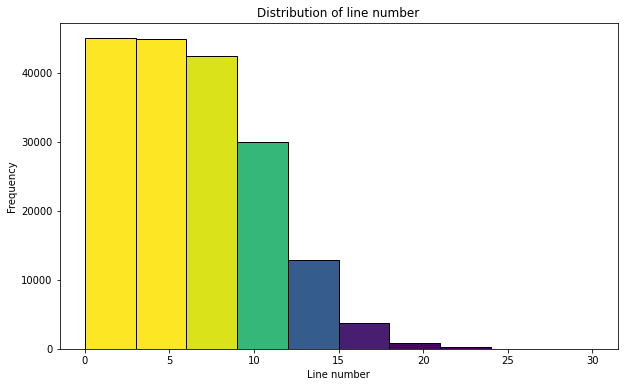

In [89]:
# Check the distribution of "line_number" column
plot_hist(train_df['line_number'], 'Distribution of line number', 'Line number', 'Frequency', bins_number = 10)    


We cut it into 15 so that the vector is not too long, and as seen in the previous histogram,
the majority of our data falls in there.

In [90]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [91]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

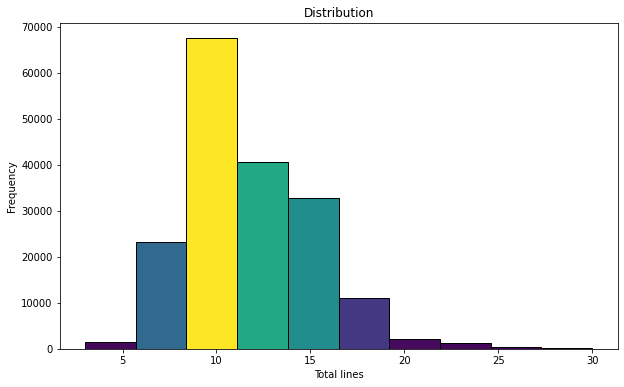

In [93]:
# Check the distribution of "line_number" column
plot_hist(train_df['total_lines'], 'Distribution', 'Total lines', 'Frequency', bins_number = 10) 

In [94]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [96]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for test
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [98]:
# take the first element
first_element_dataset = train_char_token_pos_dataset.take(1)

# convert the dataset to a list and get the first element
first_element = list(first_element_dataset.as_numpy_iterator())[0]

first_element

((array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [99]:
def build_model_5(name):
    # 1. Token inputs
    token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
    token_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs,
                                 outputs=token_outputs)

    # 2. Char inputs
    char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embed(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs,
                                outputs=char_bi_lstm)

    # 3. Line numbers model
    line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
    x = layers.Dense(32, activation="relu")(line_number_inputs)
    # combine inputs & dense layer into model
    line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                       outputs=x)

    # 4. Total lines model
    total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
    y = layers.Dense(32, activation="relu")(total_lines_inputs)
    total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                       outputs=y)

    # 5. Combine token and char embeddings into a hybrid embedding
    combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                  char_model.output])

    z = layers.Dense(256, activation="relu")(combined_embeddings)
    z = layers.Dropout(0.5)(z)

    # 6. Combine positional embedding with combined token and char embeddings
    tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                     total_lines_model.output,
                                                                                     z])

    # 7. Create output layer
    output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

    # 8. Put together model with all kinds of inputs
    model = tf.keras.Model(inputs=[line_number_model.input,
                                     total_lines_model.input,
                                     token_model.input,
                                     char_model.input],
                             outputs=output_layer,
                             name=name)
    
    # return
    return model


model_5 = build_model_5('Model_5')

model_5.summary()


Model: "Model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

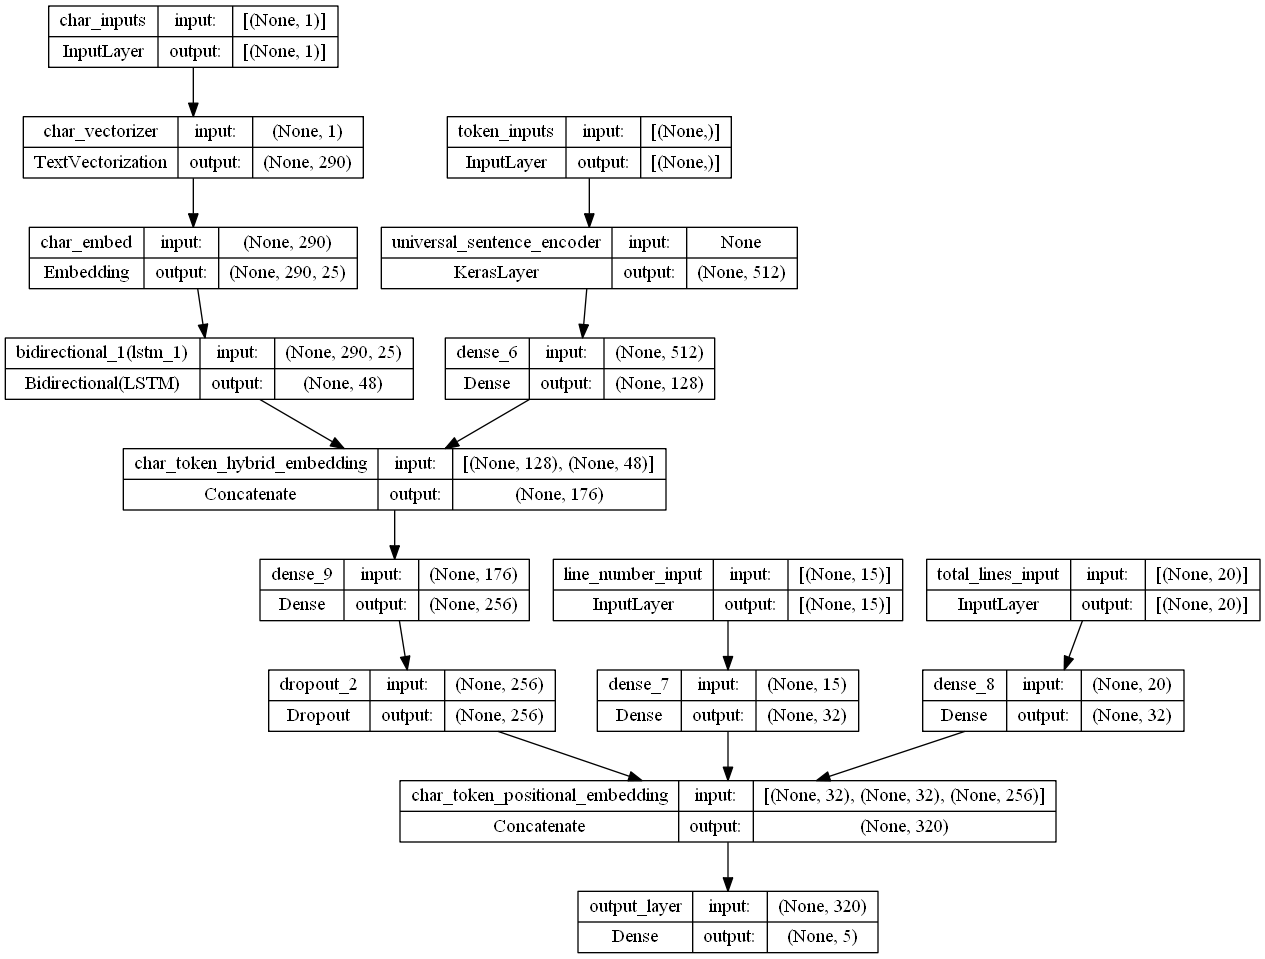

In [100]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [101]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'Precision', 'Recall'])

# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 214s 334ms/step - loss: 1.1074 - accuracy: 0.7119 - precision: 0.8634 - recall: 0.4866 - val_loss: 0.9861 - val_accuracy: 0.8068 - val_precision: 0.8771 - val_recall: 0.6546
Epoch 2/3
562/562 [==============================] - 158s 281ms/step - loss: 0.9688 - accuracy: 0.8156 - precision: 0.8811 - recall: 0.6840 - val_loss: 0.9523 - val_accuracy: 0.8241 - val_precision: 0.8966 - val_recall: 0.6948
Epoch 3/3
562/562 [==============================] - 95s 169ms/step - loss: 0.9509 - accuracy: 0.8207 - precision: 0.8879 - recall: 0.7052 - val_loss: 0.9413 - val_accuracy: 0.8268 - val_precision: 0.8970 - val_recall: 0.7178


In [102]:
score5 = model_5.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 35s 37ms/step - loss: 0.9475 - accuracy: 0.8280 - precision: 0.8894 - recall: 0.7062


In [103]:
store_results(results, 'Model 5', score5);

In [105]:
# Make predictions 
model_5_pred_probs = model_5.predict(test_char_token_pos_dataset)
model_5_pred_probs

942/942 [==============================] - 33s 32ms/step


array([[0.35388878, 0.08695734, 0.03659717, 0.48567197, 0.03688474],
       [0.36406782, 0.07457716, 0.1457225 , 0.37163758, 0.04399482],
       [0.07516703, 0.02583762, 0.76206124, 0.09667245, 0.04026162],
       ...,
       [0.07253072, 0.08278575, 0.08219761, 0.0623647 , 0.7001213 ],
       [0.06922343, 0.07413439, 0.08296545, 0.05538367, 0.7182931 ],
       [0.09437669, 0.5478307 , 0.13905112, 0.06028216, 0.15845942]],
      dtype=float32)

In [106]:
# Format pred probs into pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1], dtype=int64)>

<a name="6"></a>
## <b> <font color='blue'> 6. Compare results </font> </b>

In [147]:
# Convert dictionary to DataFrame
df_metrics = pd.DataFrame(results).T  # .T transposes the DataFrame for easier viewing
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={'index': 'Model'}, inplace=True)

# Display the DataFrame
df_metrics

,Model,accuracy,precision,recall,f1_score
0,Model 1,0.778464,0.831754,0.701809,0.761276
1,Model 2,0.782811,0.820308,0.734561,0.775070
2,Model 3,0.448349,0.658976,0.194292,0.300103
3,Model 4,0.723677,0.799582,0.634810,0.707732
4,Model 5,0.828040,0.889376,0.706189,0.787267
5,Baseline,0.721832,0.718647,0.721832,0.720236


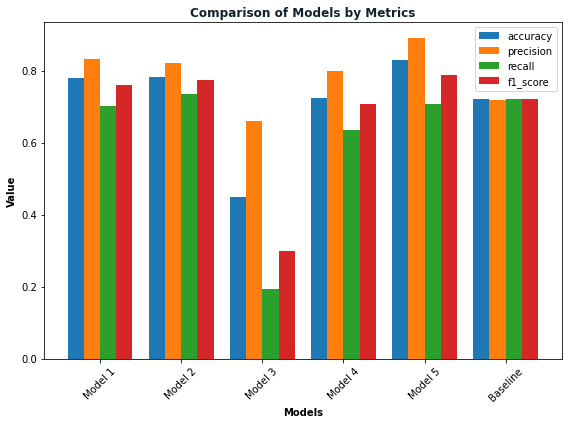

In [148]:
# Extract data
models = list(results.keys())
metrics = list(results[models[0]].keys())
values = {metric: [] for metric in metrics}

for model in models:
    for metric in metrics:
        values[metric].append(results[model][metric])

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[metric], width, label=metric)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Value', fontweight='bold')
ax.set_title('Comparison of Models by Metrics', fontweight='bold', color='#12222C')
ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


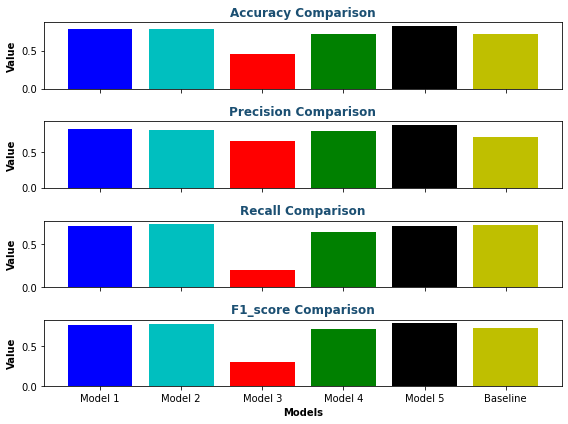

In [149]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(8, 6), sharex=True)

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    axs[i].bar(models, values, color=['b', 'c', 'r', 'g', 'k', 'y', 'm'])
    axs[i].set_title(f'{metric.capitalize()} Comparison', fontweight='bold', color='#1B4F72')
    axs[i].set_ylabel('Value', fontweight='bold')

axs[-1].set_xlabel('Models', fontweight='bold')

plt.tight_layout()
plt.show()

In [150]:
# Find the index of the row with the highest F1 score
highest_f1_index = df_metrics['f1_score'].idxmax()

# Get the model with the highest F1 score
best_model = df_metrics.loc[highest_f1_index]

print(f"Model with the highest F1 score:\n{best_model}")

Model with the highest F1 score:
Model         Model 5
accuracy      0.82804
precision    0.889376
recall       0.706189
f1_score     0.787267
Name: 4, dtype: object


<a name="7"></a>
## <b> <font color='blue'> 7. Conclusions </font> </b>

Different machine learning models were tested for a skimlit problem using token embeddings, char embeddings, and even a combination of both, with the best model achieving an F1-score of 78% after being trained for just 3 epochs


<a name="8"></a>
## <b> <font color='blue'> 8.  References </font> </b>

This notebook is heavily inspired by [TF Developer Certificate](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb)
